# Convert dataset to Parquet 

In [56]:
import os
import json
import pandas as pd
import argparse
from pathlib import Path
from tqdm import tqdm

def convert_json_to_parquet(input_dir, output_dir):
    """
    Recursively finds all JSON files in input_dir and converts them to Parquet,
    maintaining the same directory structure in output_dir.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all JSON files recursively
    json_files = list(Path(input_dir).glob('**/*.json'))
    
    print(f"Found {len(json_files)} JSON files to convert")
    
    for json_path in tqdm(json_files):
        # Calculate the relative path to maintain directory structure
        rel_path = json_path.relative_to(input_dir)
        output_path = Path(output_dir) / rel_path.with_suffix('.parquet')
        
        # Create the parent directories if they don't exist
        os.makedirs(output_path.parent, exist_ok=True)
        
        # Load the JSON file
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # If it's a list of records, convert directly
        if isinstance(data, list):
            df = pd.DataFrame(data)
        # If it's a single record, wrap it in a list
        else:
            df = pd.DataFrame([data])
        
        # Write to Parquet
        df.to_parquet(output_path, index=False)
        
        print(f"Converted {json_path} to {output_path}")

if __name__ == "__main__":
    convert_json_to_parquet("c5/experiment_5", "c5/experiment_5_parquet")
    # convert_json_to_parquet("before-arc-parquet/compositionality/", "before-arc-parquet/compositionality/")
    print("Conversion complete!")

Found 5 JSON files to convert


 40%|████      | 2/5 [00:00<00:00, 12.98it/s]

Converted c5/experiment_5/test.json to c5/experiment_5_parquet/test.parquet
Converted c5/experiment_5/test_ood.json to c5/experiment_5_parquet/test_ood.parquet
Converted c5/experiment_5/val_ood.json to c5/experiment_5_parquet/val_ood.parquet


 80%|████████  | 4/5 [00:07<00:02,  2.26s/it]

Converted c5/experiment_5/train.json to c5/experiment_5_parquet/train.parquet


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]

Converted c5/experiment_5/val.json to c5/experiment_5_parquet/val.parquet
Conversion complete!


# Upload dataset to Hugging Face

In [2]:
import os
os.listdir('../../cogitao-dev')

['generalization',
 'README.md',
 '.gitattributes',
 '.git',
 'sample_efficiency',
 'compositionality']

In [57]:
from huggingface_hub import HfApi
import os
api = HfApi(token=os.getenv("HF_TOKEN"))
api.upload_folder(
    folder_path="c5/experiment_5",
    path_in_repo="CompGen/exp_setting_5/experiment_5",
    repo_id="yassinetb/cogitao",
    repo_type="dataset",
    commit_message="Upload C-5",
    ignore_patterns=["*.db"]
)




Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]


test.parquet: 100%|██████████| 98.4k/98.4k [00:00<00:00, 292kB/s]
val.parquet: 100%|██████████| 97.1k/97.1k [00:00<00:00, 164kB/s]]
val_ood.parquet: 100%|██████████| 107k/107k [00:00<00:00, 158kB/s]
train.parquet: 100%|██████████| 9.12M/9.12M [00:00<00:00, 9.40MB/s]
Upload 4 LFS files: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/yassinetb/COGITAO/commit/627d417b8f5ac5404c672d785b6504a7737a8a9e', commit_message='Upload C-5', commit_description='', oid='627d417b8f5ac5404c672d785b6504a7737a8a9e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/yassinetb/COGITAO', endpoint='https://huggingface.co', repo_type='dataset', repo_id='yassinetb/COGITAO'), pr_revision=None, pr_num=None)

# Verify Croissant Meta Data

In [1]:
import requests
# headers = {"Authorization": f"Bearer {API_TOKEN}"}
API_URL = "https://huggingface.co/api/datasets/yassinetb/cogitao/croissant"
def query():
    response = requests.get(API_URL)
    return response.json()
data = query()
print(data)

{'@context': {'@language': 'en', '@vocab': 'https://schema.org/', 'arrayShape': 'cr:arrayShape', 'citeAs': 'cr:citeAs', 'column': 'cr:column', 'conformsTo': 'dct:conformsTo', 'cr': 'http://mlcommons.org/croissant/', 'data': {'@id': 'cr:data', '@type': '@json'}, 'dataBiases': 'cr:dataBiases', 'dataCollection': 'cr:dataCollection', 'dataType': {'@id': 'cr:dataType', '@type': '@vocab'}, 'dct': 'http://purl.org/dc/terms/', 'extract': 'cr:extract', 'field': 'cr:field', 'fileProperty': 'cr:fileProperty', 'fileObject': 'cr:fileObject', 'fileSet': 'cr:fileSet', 'format': 'cr:format', 'includes': 'cr:includes', 'isArray': 'cr:isArray', 'isLiveDataset': 'cr:isLiveDataset', 'jsonPath': 'cr:jsonPath', 'key': 'cr:key', 'md5': 'cr:md5', 'parentField': 'cr:parentField', 'path': 'cr:path', 'personalSensitiveInformation': 'cr:personalSensitiveInformation', 'recordSet': 'cr:recordSet', 'references': 'cr:references', 'regex': 'cr:regex', 'repeated': 'cr:repeated', 'replace': 'cr:replace', 'sc': 'https://

In [2]:
# Save the data to a JSON file
import json
with open("cogitao.croissant.json", "w") as f:
    json.dump(data, f, indent=4)

# Verify All Is Well with The Data

In [30]:
from datasets import load_dataset

transformation_per_experiment = {}

for i in range(5):
    for train_test in ["train", "test_ood"]:
        print(f"Loading experiment {i+1} - {train_test}")
        dataset = load_dataset("yassinetb/COGITAO", data_files={"data": f"CompGen/exp_setting_4/experiment_{i+1}/{train_test}.parquet"})
        transformation_dict = {}
        for j in range(len(dataset["data"])):
            transformation = str(dataset["data"][j]["transformation_suite"])
            if transformation not in list(transformation_dict.keys()):
                transformation_dict[transformation] = 0
            transformation_dict[transformation] += 1

        transformation_per_experiment[(i, train_test)] = transformation_dict

Loading experiment 1 - train
Loading experiment 1 - test_ood
Loading experiment 2 - train
Loading experiment 2 - test_ood
Loading experiment 3 - train


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Generating data split: 100000 examples [00:00, 137979.60 examples/s]


Loading experiment 3 - test_ood
Loading experiment 4 - train


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Generating data split: 100000 examples [00:00, 144988.90 examples/s]


Loading experiment 4 - test_ood
Loading experiment 5 - train


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Generating data split: 100000 examples [00:00, 168609.34 examples/s]


Loading experiment 5 - test_ood


In [31]:
transformation_per_experiment

{(0, 'train'): {"['mirror_horizontal']": 16670,
  "['crop_top_side']": 16666,
  "['double_right']": 16666,
  "['mirror_horizontal', 'crop_top_side']": 16666,
  "['mirror_horizontal', 'double_right']": 16666,
  "['crop_top_side', 'double_right']": 16666},
 (0, 'test_ood'): {"['double_right', 'mirror_horizontal']": 1000},
 (1, 'train'): {"['mirror_horizontal']": 4780,
  "['crop_top_side']": 4761,
  "['double_right']": 4761,
  "['translate_up']": 4761,
  "['rot90']": 4761,
  "['mirror_vertical']": 4761,
  "['mirror_horizontal', 'crop_top_side']": 4761,
  "['mirror_horizontal', 'double_right']": 4761,
  "['mirror_horizontal', 'translate_up']": 4761,
  "['mirror_horizontal', 'rot90']": 4761,
  "['mirror_horizontal', 'mirror_vertical']": 4761,
  "['crop_top_side', 'double_right']": 4761,
  "['crop_top_side', 'translate_up']": 4761,
  "['crop_top_side', 'rot90']": 4761,
  "['crop_top_side', 'mirror_vertical']": 4761,
  "['double_right', 'translate_up']": 4761,
  "['double_right', 'rot90']": 4

In [49]:
from datasets import load_dataset
# dataset = load_dataset("yassinetb/COGITAO", data_files={"data": "supplementary/CompGen_GridSize/exp_setting_1/experiment_1/grid_size_30/train.parquet"})
dataset = load_dataset("yassinetb/COGITAO", data_files={"data": "CompGen/exp_setting_4/experiment_1/test_ood.parquet"})

print(dataset["data"][0].keys())

dict_keys(['input', 'output', 'transformation_suite', 'task_key'])


In [50]:
transformation_dict = {}

for i in range(len(dataset["data"])):
    transformation = str(dataset["data"][i]["transformation_suite"])
    if transformation not in list(transformation_dict.keys()):
        transformation_dict[transformation] = 0
    transformation_dict[transformation] += 1

print(transformation_dict)

{"['double_right', 'mirror_horizontal']": 1000}


['double_right', 'mirror_horizontal']


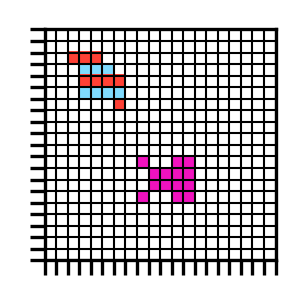

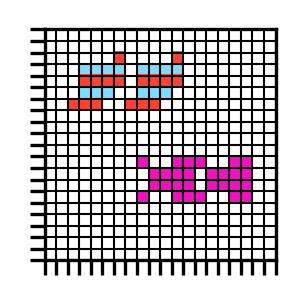

In [52]:
transformation_dict
import sys
sys.path.append('../')
from arcworld.general_utils import plot_grid

index = 100

plot_grid(dataset["data"][index]["input"], size = (1,1))
plot_grid(dataset["data"][index]["output"], size = (1,1))
print(dataset["data"][index]["transformation_suite"])


# DEPRECATED - Utils to move things around

In [2]:
# Write some code to rename every .parquet file inside of the before-arc-parquet folder in such a way that "train_val" gets renamed with "val" and "test_val" gets rename with "val_ood"

import os
from pathlib import Path

def rename_parquet_files(input_dir):
    """
    Renames .parquet files in the input_dir such that:
    - "train_val" is replaced with "val"
    - "test_val" is replaced with "val_ood"
    """
    parquet_files = list(Path(input_dir).rglob("*.parquet"))
    print(f"Found {len(parquet_files)} .parquet files to rename.")

    for file_path in parquet_files:
        new_name = file_path.name.replace("test", "test_ood")
        new_path = file_path.with_name(new_name)

        if new_name != file_path.name:
            file_path.rename(new_path)
            print(f"Renamed: {file_path} -> {new_path}")

# Call the function with the target directory
rename_parquet_files("before-arc-parquet/")

Found 133 .parquet files to rename.
Renamed: before-arc-parquet/compositionality/exp_setting_1/experiment_3/test.parquet -> before-arc-parquet/compositionality/exp_setting_1/experiment_3/test_ood.parquet
Renamed: before-arc-parquet/compositionality/exp_setting_1/experiment_4/test.parquet -> before-arc-parquet/compositionality/exp_setting_1/experiment_4/test_ood.parquet
Renamed: before-arc-parquet/compositionality/exp_setting_1/experiment_2/test.parquet -> before-arc-parquet/compositionality/exp_setting_1/experiment_2/test_ood.parquet
Renamed: before-arc-parquet/compositionality/exp_setting_1/experiment_1/test.parquet -> before-arc-parquet/compositionality/exp_setting_1/experiment_1/test_ood.parquet
Renamed: before-arc-parquet/compositionality/exp_setting_4/experiment_1/test.parquet -> before-arc-parquet/compositionality/exp_setting_4/experiment_1/test_ood.parquet
Renamed: before-arc-parquet/compositionality/exp_setting_2/experiment_3/test.parquet -> before-arc-parquet/compositionality/

In [ ]:
import os
from pathlib import Path
import shutil

def move_parquet_files(source_dir, target_dir, file_name):
    """
    Moves all files with the specified file_name from source_dir to target_dir,
    maintaining the directory structure.
    """
    source_files = list(Path(source_dir).rglob(f"**/{file_name}"))
    print(f"Found {len(source_files)} files named '{file_name}' to move.")

    for file_path in source_files:
        # Calculate the relative path to maintain directory structure
        rel_path = file_path.relative_to(source_dir)
        target_path = Path(target_dir) / rel_path

        # Create the parent directories in the target directory if they don't exist
        os.makedirs(target_path.parent, exist_ok=True)

        # Move the file
        shutil.move(str(file_path), str(target_path))
        print(f"Moved: {file_path} -> {target_path}")

# Move files for the generalization folder
move_parquet_files(
    "before_arc_datasets/generalization",
    "before-arc-parquet/generalization",
    "train_iid.parquet"
)

# Move files for the compositionality folder
move_parquet_files(
    "before_arc_datasets/compositionality",
    "before-arc-parquet/compositionality",
    "train_iid.parquet"
)

In [10]:
import os
from pathlib import Path

def delete_non_train_parquet_files(directory):
    """
    Deletes all .parquet files in the specified directory (and its subdirectories)
    that do not contain the string 'train' in their filename.
    """
    parquet_files = list(Path(directory).rglob("*.parquet"))
    print(f"Found {len(parquet_files)} .parquet files to check.")

    for file_path in parquet_files:
        print(file_path)
        if "train_val" in file_path.name:
            file_path.unlink()  # Delete the file
            print(f"Deleted: {file_path}")
        elif "test_val" in file_path.name:
            file_path.unlink()
            print(f"Deleted: {file_path}")

# Call the function with the target directory
delete_non_train_parquet_files("before-arc-parquet/")

Found 165 .parquet files to check.
before-arc-parquet/compositionality/exp_setting_1/experiment_3/test.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_3/val_ood.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_3/val.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_3/train.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_3/test_ood.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_4/test.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_4/val_ood.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_4/val.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_4/train.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_4/test_ood.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_2/test.parquet
before-arc-parquet/compositionality/exp_setting_1/experiment_2/val_ood.parquet
before-arc-parquet/compositionality/

In [4]:
import os
from pathlib import Path
import shutil

def move_all_parquet_files(source_dir, target_dir):
    """
    Moves all .parquet files from source_dir to the corresponding subdirectories in target_dir.
    Assumes the subdirectories already exist in the target directory.
    """
    parquet_files = list(Path(source_dir).rglob("*.parquet"))
    print(f"Found {len(parquet_files)} .parquet files to move.")

    for file_path in parquet_files:
        # Calculate the relative path to maintain directory structure
        rel_path = file_path.relative_to(source_dir)
        target_path = Path(target_dir) / rel_path

        # Move the file
        shutil.move(str(file_path), str(target_path))
        print(f"Moved: {file_path} -> {target_path}")

# Call the function with the source and target directories
move_all_parquet_files("before_arc_datasets", "before-arc-parquet")


Found 132 .parquet files to move.
Moved: before_arc_datasets/compositionality/exp_setting_1/experiment_3/test.parquet -> before-arc-parquet/compositionality/exp_setting_1/experiment_3/test.parquet
Moved: before_arc_datasets/compositionality/exp_setting_1/experiment_3/val_ood.parquet -> before-arc-parquet/compositionality/exp_setting_1/experiment_3/val_ood.parquet
Moved: before_arc_datasets/compositionality/exp_setting_1/experiment_3/val.parquet -> before-arc-parquet/compositionality/exp_setting_1/experiment_3/val.parquet
Moved: before_arc_datasets/compositionality/exp_setting_1/experiment_3/test_ood.parquet -> before-arc-parquet/compositionality/exp_setting_1/experiment_3/test_ood.parquet
Moved: before_arc_datasets/compositionality/exp_setting_1/experiment_4/test.parquet -> before-arc-parquet/compositionality/exp_setting_1/experiment_4/test.parquet
Moved: before_arc_datasets/compositionality/exp_setting_1/experiment_4/val_ood.parquet -> before-arc-parquet/compositionality/exp_setting_1

In [6]:
import os
from pathlib import Path

def delete_json_files(directory):
    """
    Deletes all .json files in the specified directory (and its subdirectories).
    """
    json_files = list(Path(directory).rglob("*.json"))
    print(f"Found {len(json_files)} .json files to delete.")

    for file_path in json_files:
        file_path.unlink()  # Delete the file
        print(f"Deleted: {file_path}")

# Call the function with the target directory
delete_json_files("before-arc-parquet/")

Found 4 .json files to delete.
Deleted: before-arc-parquet/compositionality/exp_setting_4/experiment_1/train.json
Deleted: before-arc-parquet/compositionality/exp_setting_4/experiment_1/test_val.json
Deleted: before-arc-parquet/compositionality/exp_setting_4/experiment_1/train_val.json
Deleted: before-arc-parquet/compositionality/exp_setting_4/experiment_1/test.json


In [37]:
from generator import generator
from arcworld.general_utils import plot_grid
from experiment_configs.c4 import c4_configs
print(c4_configs[1])
ood_config = c4_configs[1]
ood_config["allowed_combinations"].append(["mirror_horizontal", "double_right"])
gen = generator(ood_config)
            

{'min_n_shapes_per_grid': 2, 'max_n_shapes_per_grid': 2, 'n_examples': 1, 'min_grid_size': 20, 'max_grid_size': 20, 'allowed_combinations': [['double_right', 'rot90'], ['rot90', 'double_right'], ['rot90', 'double_right']], 'allowed_transformations': None, 'min_transformation_depth': None, 'max_transformation_depth': None, 'shape_compulsory_conditionals': ['is_shape_less_than_6_rows', 'is_shape_less_than_6_cols', 'is_shape_fully_connected'], 'saving_path': 'before_arc_datasets/c4_newversion/exp_setting_4/experiment_1/test.json'}


['mirror_horizontal', 'double_right']


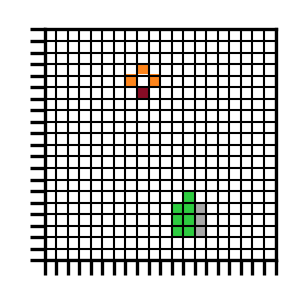

In [48]:
transform_suite = gen.sample_transform_suite()
print(transform_suite)
task_shape_constraints = gen.get_shape_constraints_from_rule_sampled(transform_suite)
compatible_shape_rows = gen.get_compatible_shape_rows(
    shape_conditionals_to_satisfy=gen.config.shape_compulsory_conditionals,
    shape_conditionals_not_to_satisfy=task_shape_constraints
)


input_grid, shapes_positionned = gen.set_up_initial_grid(compatible_shape_rows=compatible_shape_rows)
plot_grid(input_grid, size=(1,1))

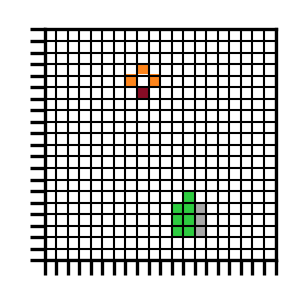

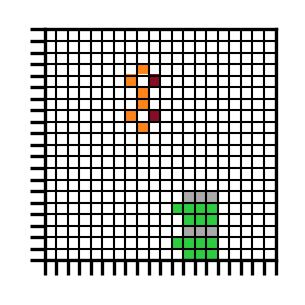

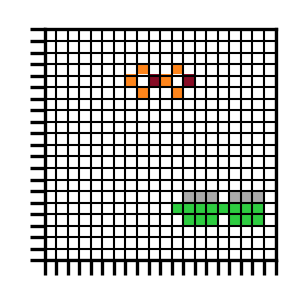

In [49]:
plot_grid(input_grid, size=(1,1))
t_suite_ordered = ["double_right", "rot90"]
t_suite_disordered = ["rot90", "double_right"]

output_grid_ordered = gen.apply_transform_suite_to_grid(t_suite_ordered, 
                                                        input_grid, 
                                                        shapes_positionned)
output_grid_disordered = gen.apply_transform_suite_to_grid(t_suite_disordered, 
                                                           input_grid, 
                                                           shapes_positionned)

plot_grid(output_grid_ordered, size=(1,1))
plot_grid(output_grid_disordered, size=(1,1))